## ABOUT THIS NOTEBOOK
***
<div style="text-align: justify;">
The ongoing tectonic activity within the Earth's crust gradually builds stress and pressure along fault lines. Once the accumulating shear stress exceeds the fault's resistance, earthquakes occur as a sudden release of energy. In tectonically active regions, maintaining a record of seismic events is crucial to mitigate risks to human safety. These records, known as earthquake catalogs, are invaluable tools for understanding seismicity, earthquake physics and conducting hazard analysis to improve preparedness and reduce potential impacts (<a href="https://doi.org/10.1785/0120040007">Woessner and Wiemer, 2005</a>). <br>
<br>
Most catalogs today use different magnitude scales to measure the size of an earthquake. Seismic events are initially measured on the local magnitude scale $M_L$, which derives the magnitude based on the maximum amplitude measured on the Wood-Anderson seismometer (<a href="https://doi.org/10.1785/gssrl.42.3-4.21">Richter, 1935</a>). This scale was later improved to estimate teleseismic events by measuring seismic wave phases. Surface-wave magnitude ($M_s$) scale was developed to measure earthquake size based on the amplitude of Rayleigh waves with periods of about 20 seconds. This magnitude scale was immediately followed by the body-wave magnitude ($m_b$) scale that measures seismic events based on the ratio of amplitude to period of P- or S-waves with periods up to about 10 seconds (<a href="https://doi.org/10.1785/BSSA0350020057">Gutenberg, 1945a</a>, <a href="https://doi.org/10.1785/BSSA0350030117">b</a>; <a href="https://doi.org/10.1038/176795a0">Gutenberg and Richter, 1955</a>). <br>
<br>
The three established scales rely on maximum amplitude of seismic waves to measure earthquake size. However, for large earthquakes, the amplitude saturates because it reaches a maximum limit, making it challenging to accurately measure very large events. This limitation led to the development of the moment magnitude scale ($M_W$), which measures earthquake size based on the seismic moment rather than maximum amplitude. Seismic moment is the physical representation of energy released by the earthquake, and is a function of rigidity (shear modulus) of surrounding rock, average dispacement along the fault, and fault area. Since $M_W$ is logarithmically proportional to seismic moment, it provides a more accurate measurement of small to very large earthquakes, avoiding the saturation problems seen in earlier scales (<a href="https://doi.org/10.1029/JB082i020p02981">Kanamori, 1977</a>; <a href="https://doi.org/10.1029/JB084iB05p02348">Hanks and Kanamori, 1979</a>). This makes the $M_W$ the preferred scale for compiling earthquake catalogs and widely used in seismic hazard analysis and engineering applications (<a href="https://doi.org/10.1007/s11069-011-9796-6">Das et al., 2011</a>).<br>
<br>
This notebook demonstrates the conversion of magnitude scales $M_L$, $M_s$, and $m_b$ into $M_W$ to create a homogenized earthquake catalog. It also explores ways to extract key seismic parameters derived from the catalog such as completeness magnitude ($M_c$) and Gutenberg-Richter law variables, <span style="font-style: italic;">a</span>- and <span style="font-style: italic;">b</span>-values. Refining the catalog follows the approach used by <a href="https://doi.org/10.5194/nhess-21-2059-2021">Tan (2021)</a>, which considers only events recorded during the modern instrumental period then applies declustering, $M_c$-based filtering, and outlier removal.
</div>



## DATA USED
***
<div style="text-align: justify;">
<ol>
  <li>
    <strong>Philippine Earthquake Catalog</strong> – This dataset contains earthquake events retrieved from the 
    <a href="https://doi.org/10.31905/D808B830">Bulletin of the International Seismological Center</a>. Since reviewed events are typically 24 months before current day, the data used for this analysis is spans from 1 January 1901 until 31 December 2022. The retrieved dataset covers the region bounded by $4-21^\circ$ N and $115-130^\circ$ E.
  </li>
  <li>
    <strong>Philippine Tectonic Data</strong> – This dataset contains information on active faults and trenches, downloaded from the Global Earthquake Model (GEM) Global Active Faults Database (<a href="https://doi.org/10.5281/zenodo.3376300">Styron, 2019</a>; <a href="https://doi.org/10.1177/8755293020944182">Styron and Pagani, 2020</a>). The data is provided in a Generic Mapping Tools (GMT)-readable format, for easier analysis and visualization.
  </li>
</ol>
</div>

## DATA ANALYSIS
***

Load libraries

In [631]:
# Data analysis
import math
import numpy as np
import pandas as pd

# File handling
import os

# Geospatial data processing
import pygmt

# Seismic data processing
import bruces
from bruces.decluster import nearest_neighbor
import csep

# Statistical analysis
from scipy.optimize import curve_fit
from scipy.special import gammaln
#from scipy.stats import norm

# Visualization Tools
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

### Import Data

In [633]:
workdir = os.path.join(os.getcwd(), 'Documents', 'data_analytics', 'eq_analysis')

# Earthquake catalog
isc_cat = os.path.join(workdir, 'master.xlsx')
master_df = pd.read_excel(isc_cat)

print(f'The catalog of earthquake events from 1900 to 2022 contains {master_df.shape[0]} events.')

master_df.head(3)

The catalog of earthquake events from 1900 to 2022 contains 88123 events.


,EVENTID,TYPE,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR .1,...,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119
0,16957747,ke,CENT,1901-12-14,22:57:00,14.0,122.0,0,,AN2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16957808,ke,CENT,1903-12-28,02:56:00,7.0,127.0,0,,P&S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16957908,ke,CENT,1906-06-19,11:22:41,20.0,122.0,60,,BJI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### I. Cleaning Data

In [635]:
# Check column headers
master_df.columns

Index(['EVENTID', 'TYPE', 'AUTHOR   ', 'DATE      ', 'TIME       ', 'LAT     ',
       'LON      ', 'DEPTH', 'DEPFIX', 'AUTHOR   .1',
       ...
       'Unnamed: 110', 'Unnamed: 111', 'Unnamed: 112', 'Unnamed: 113',
       'Unnamed: 114', 'Unnamed: 115', 'Unnamed: 116', 'Unnamed: 117',
       'Unnamed: 118', 'Unnamed: 119'],
      dtype='object', length=120)

In [636]:
# Rename 'TYPE' column
master_df.rename(columns={'TYPE': 'EVENT_TYPE'}, inplace=True)

# Remove extra spaces in column names
master_df = master_df.rename(columns=lambda x: "".join(x.split()))
#master_df.columns

In [637]:
# Drop 'AUTHOR' column
if 'AUTHOR' in master_df.columns.tolist():
    master_df = master_df.drop('AUTHOR', axis=1)
else:
    pass

# Set date column to datetime format
master_df['DATE'] = pd.to_datetime(master_df['DATE'])

# Display unique values after stripping spaces (in column 'Author.1' to last column)
unique_values = pd.unique(master_df.loc[:, 'AUTHOR.1':'Unnamed:119'].values.ravel('K'))
unique_values

array(['AN2      ', 'P&S      ', 'BJI      ', 'PAS      ', 'ISC      ',
       'USCGS    ', 'MAN      ', 'NEIC     ', 'PEK      ', 'TAP      ',
       'EIDC     ', 'IDC      ', 'DJA      ', 'KLM      ', 'BGR      ',
       'Ms    ', 'mb    ', 'MS    ', 'mL    ', 'md    ', 'ML    ',
       'MLv   ', 7.0, 7.3, 7.6, 7.4, 6.8, 6.9, 7.7, 7.5, 7.8, 6.5, 8.0,
       6.4, 5.9, 6.6, 6.2, 6.3, 7.2, 6.1, 5.6, 6.7, 6.0, 7.1, 5.8, 5.7,
       5.5, 5.4, 5.2, 4.8, 4.6, 5.1, 5.0, 4.9, 5.3, 4.4, 4.7, 4.5, 4.2,
       4.3, 4.1, 4.0, 3.8, 3.9, 3.6, 3.5, 3.7, 3.1, 3.3, 3.2, 3.0, 3.4,
       2.7, 2.6, 2.2, 2.9, 2.5, 2.8, 2.3, 2.1, 2.0, 1.9, 1.8, 0.7, 2.4,
       1.7, 1.3, 1.6, 0.0, 1.2, 1.1, 1.4, 1.5, 1.0, 0.9, 0.8, nan,
       'ABE1     ', 'STR      ', 'PRA      ', 'KIR      ', 'ROM      ',
       'UPP      ', 'ISS      ', 'MOS      ', 'ROTHE    ', 'MAT      ',
       'QUE      ', 'GCMT     ', 'NEIS     ', 'LDG      ', 'NIED     ',
       'JMA      ', 'CSEM     ', 'SZGRF    ', 'BKK      ', 'GFZ      ',
  

<div style="text-align: justify;">
Seismological institutions use different notations for magnitude scales when recording earthquake events, which reflect different techniques used for processing waveforms of their seismic network (<a href="https://www.iaspei.org/commissions/commission-on-seismological-observation-and-interpretation/Summary_WG_recommendations_20130327.pdf">IASPEI, 2013</a>; <a href="https://doi.org/10.1007/s10950-015-9543-7">Di Giacomo and Storchak, 2015</a>; <a href="https://doi.org/10.57757/IUGG23-2916">Garth et al., 2023</a>). For consistency, all magnitude scales will be standardized as follows: 'Mw' for moment magnitude, 'Ms' for surface wave magnitude, 'mb' for body wave magnitude, 'ML' for local magnitude. The notation 'M' is generally used for an unspecified magnitude scale. However, using a single letter can lead to parsing issues, so 'Mu' will be used instead. 
</div>

In [639]:
# Change 'M     ' to 'Mu'
for col in master_df.columns:
    master_df[col] = master_df[col].apply(lambda x: 'Mu' if isinstance(x, str) and x == 'M     ' else x)

# Remove extra spaces on each element of the dataframe
df = master_df.loc[:, 'EVENT_TYPE':'Unnamed:119']

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.strip()

In [640]:
def standardize_value(value):
    '''
    Function is used to standardize magnitude scales.

    Parameter:
    value (str) - a variant notation of magnitude scales.

    Output
    value (str) - standardized notation of magnitude scales.
    
    '''
    # List of magnitude scale notations found in the catalog
    ms_variants = ['MS', 'MSZ', 'msz', 'Msz', 'Ms_20', 'Ms7', 'Ms1', 'ms1mx', 'Ms(BB)']
    mw_variants = ['MW', 'Mww', 'mw', 'Mwppsm', 'Mw(mB)', 'Mwr', 'Mwp', 'Mwb', 'MwMwp', 'Mwc']
    mb_variants = ['MB', 'mB', 'mb1', 'mbtmp', 'mB_BB', 'mb1mx', 'mBc', 'Mb']
    ml_variants = ['mL', 'MLv']
    
    # Ensure 'value' is a string and strip spaces
    if isinstance(value, str):
        value = value.strip()

        # Check Ms variants
        if any(variant in value for variant in ms_variants):
            return 'Ms'
        
        # Check mb variants
        elif any(variant in value for variant in mb_variants):
            return 'mb'
        
        # Check ML variants
        elif any(variant in value for variant in ml_variants):
            return 'ML'
        
        # Check Mw variants
        elif any(variant in value for variant in mw_variants):
            return 'Mw'
    
    return value

def standardize_magnitude(df):
    # Loop through each column
    for col in df.columns:
        # Standardize values in each column
        df[col] = df[col].apply(lambda x: standardize_value(x))
    
    return df

In [641]:
df = standardize_magnitude(df)

unique_values = pd.unique(df.loc[:, 'AUTHOR.1':'Unnamed:119'].values.ravel('K'))
unique_values

array(['AN2', 'P&S', 'BJI', 'PAS', 'ISC', 'USCGS', 'MAN', 'NEIC', 'PEK',
       'TAP', 'EIDC', 'IDC', 'DJA', 'KLM', 'BGR', 'Ms', 'mb', 'ML', 'md',
       7.0, 7.3, 7.6, 7.4, 6.8, 6.9, 7.7, 7.5, 7.8, 6.5, 8.0, 6.4, 5.9,
       6.6, 6.2, 6.3, 7.2, 6.1, 5.6, 6.7, 6.0, 7.1, 5.8, 5.7, 5.5, 5.4,
       5.2, 4.8, 4.6, 5.1, 5.0, 4.9, 5.3, 4.4, 4.7, 4.5, 4.2, 4.3, 4.1,
       4.0, 3.8, 3.9, 3.6, 3.5, 3.7, 3.1, 3.3, 3.2, 3.0, 3.4, 2.7, 2.6,
       2.2, 2.9, 2.5, 2.8, 2.3, 2.1, 2.0, 1.9, 1.8, 0.7, 2.4, 1.7, 1.3,
       1.6, 0.0, 1.2, 1.1, 1.4, 1.5, 1.0, 0.9, 0.8, 'nan', 'ABE1', 'STR',
       'PRA', 'KIR', 'ROM', 'UPP', 'ISS', 'MOS', 'ROTHE', 'MAT', 'QUE',
       'GCMT', 'NEIS', 'LDG', 'NIED', 'JMA', 'CSEM', 'SZGRF', 'BKK',
       'GFZ', 'Mu', 'Mw', 'MD', nan, 7.9, 8.2, 8.3, 'AN1', 'PAL', 'EVBIB',
       'ASIES', 'BRK;NEIC', 'USGS;NEIC', 'EUROP', 'OSUNB', 'IPGP',
       'ISC-PPSM', 0.6, 0.5, 0.4, 'BRK', 'PAS;NEIC', 'GS', 'INMG', 'PTWC',
       8.1, 'ABE3', 'PAS;NEIS', 'BRK;NEIS', 'CTAO;PEK', 'USGS

<div style="text-align: justify;">
The <a href="https://doi.org/10.31905/D808B830">ISC (2025)</a> publishes its global earthquake bulletin using the IASPEI seismic format (ISF). Part of the ISF is the standard two-letter notation to classify event types. The first character indicates the level of confidence in the event classification, such a <span style="font-weight: bold;">s</span>uspected, <span style="font-weight: bold;">k</span>nown, <span style="font-weight: bold;">f</span>elt, and <span style="font-weight: bold;">d</span>amaging. The second character represents the type of event where <span style="font-weight: bold;">e</span> stands for earthquake and all other letters indicate non-seismic events. Thus, all unconfirmed (suspected) earthquakes and non-seismic events will be removed from the database. 
</div>

In [643]:
df['EVENT_TYPE'].unique()

array(['ke', 'fe', 'de', 'se', 'km'], dtype=object)

In [644]:
non_seismic = df[(df['EVENT_TYPE'] == 'km') | (df['EVENT_TYPE'] == 'se')].index

df.drop(non_seismic, inplace=True)

##### Show map of hypocenters

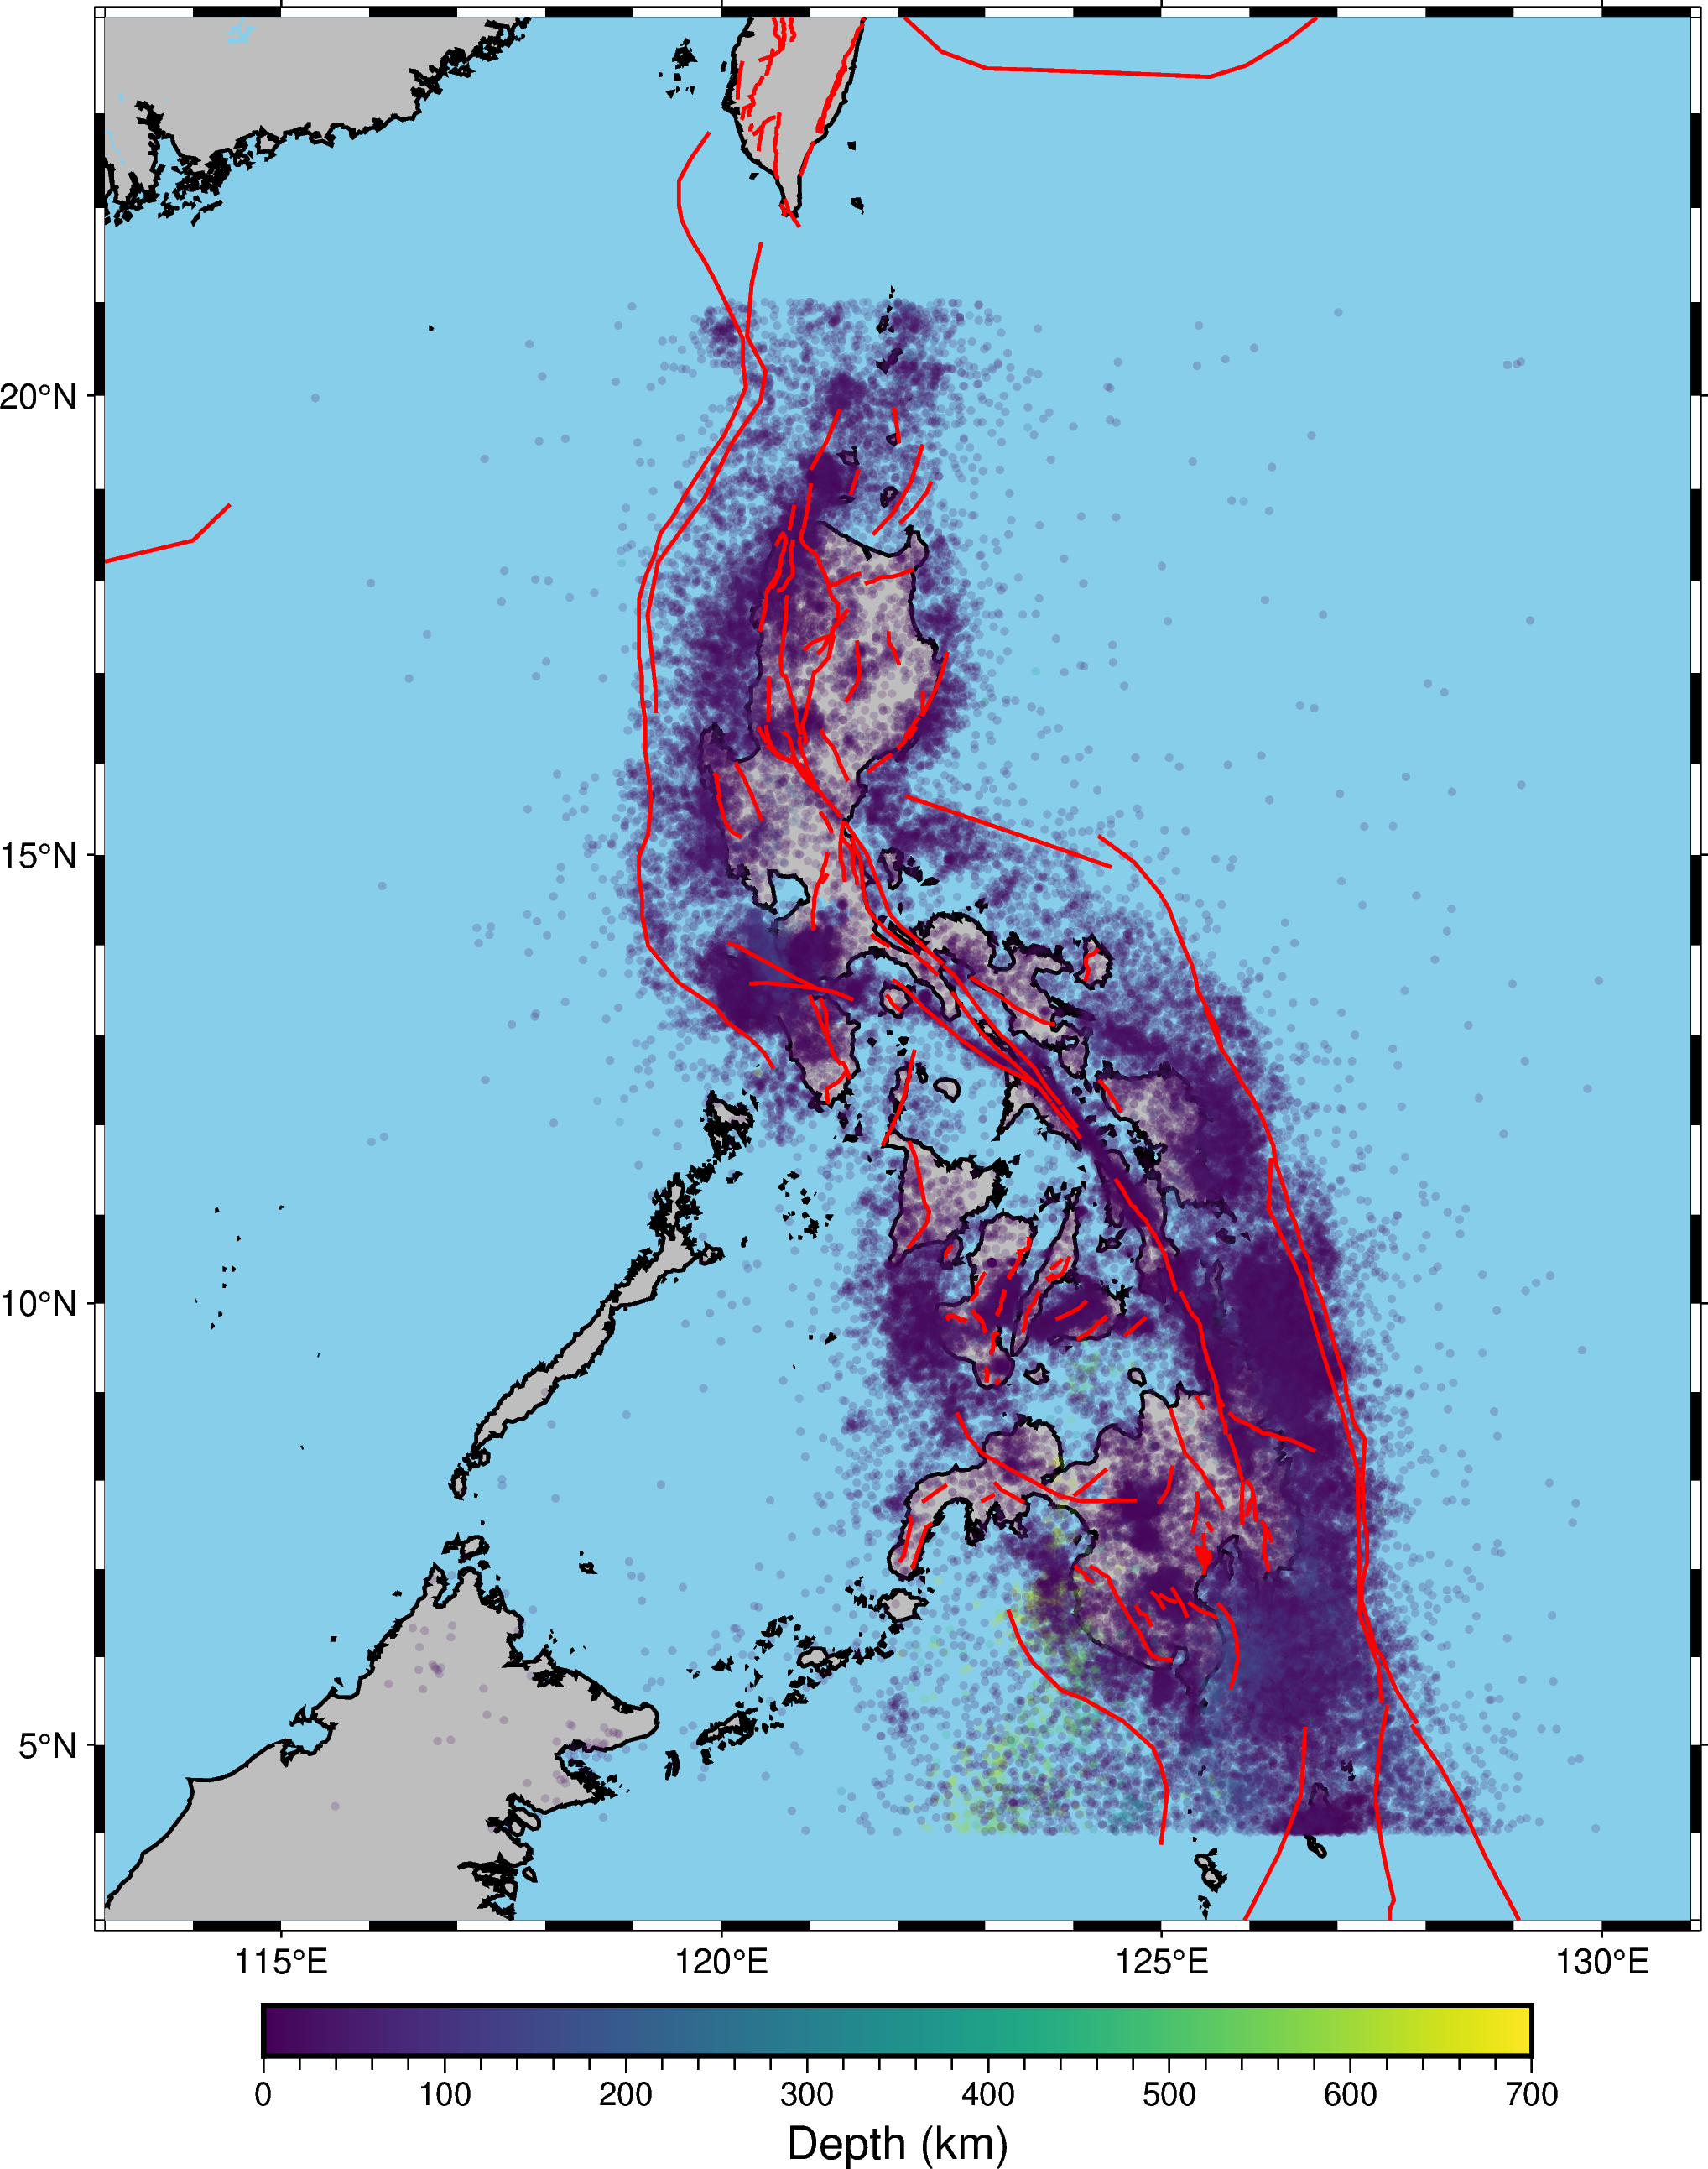

In [646]:
# Format depth column
if df['DEPTH'].dtype == 'float64': # If float, do nothing
    pass

else: # Convert to float if otherwise
    df['DEPTH'] = df['DEPTH'].replace('', np.nan) # Replace empty strings with NaN
    df['DEPTH'] = df['DEPTH'].astype(float) 

# Drop all rows where depth == NaN
no_depth = df[df['DEPTH'].isna()].index
with_depth = df.drop(no_depth)

# Load active faults file
active_faults = os.path.join(workdir, 'gem', 'gem_active_faults_harmonized.gmt')

fig = pygmt.Figure()

# Setup basemap
fig.basemap(region=[113, 131, 3, 24], # Set regional boundary
            projection="M0/0/16c", # Set projection: Mercator
            frame='af' # Set frame with grid coordinates
)

fig.coast(shorelines="1/1p", # Set shoreline thickness
         land='gray', # Set landmass color
         water='skyblue' # Set waterbody color
)

# Use depth-based color scheme
pygmt.makecpt(cmap="viridis", series=[with_depth.DEPTH.min(), with_depth.DEPTH.max()])

# Plot earthquake hypocenters
fig.plot(x=with_depth.LON,
         y=with_depth.LAT,
         style="c0.08c", # set data point diameter
         fill=with_depth.DEPTH, # Fill color
         #pen=with_depth.DEPTH, # Set outline of each datapoint
         cmap=True, # True if colormap is used
         transparency=80 
)

# Plot active faults
fig.plot(data=active_faults, 
         pen="1p,red")

# Show colorbar
fig.colorbar(frame="xaf+lDepth (km)")

fig.show()

### II. Refining Data
##### Parsing the data
<div style="text-align: justify;">
In line with the objective to create a homogeneous catalog, all earthquake events recorded in the $M_W$ scale extracted, and check whether each event was also recorded using other magnitude scales (i.e., $M_S$, $mb$, $M_L$, $M$). Each of these other magnitude scales will then be paired with the $M_W$ scale values to establish a conversion equation. Since each event in the bulletin may contain two or more values for a magnitude scale from different institutions, a database parser is created to calculate the average of all reported values for each event.
</div>

In [648]:
# Create subset df containing all events with magnitude recorded on Mw scale
def mw_checker(row):
    '''
    Function checks each row for any record of moment magnitude.

    Parameter:
    row - each line of dataframe representing an earthquake event.
    '''
    for value in row:
        if isinstance(value, str) and 'mw' in value.lower():
            return True
    return False

# Loop through each row and filter rows with Mw
new_df = df[df.apply(mw_checker, axis=1)]

print(f'The catalog contains {new_df.shape[0]} events recorded on the moment magnitude scale.')

The catalog contains 2281 events recorded on the moment magnitude scale.


In [649]:
def find_magnitude(row, magnitude_scale):
    '''
    Function loops through each column and calculates the arithmetic
    mean of all reported magnitude scale type.

    Parameters:
    row (pd.Series) - row of a dataframe.
    magnitude_scale (str) - magnitude scale to check in each row

    Output:
    mean_magnitude (float) - arithmetic mean (in nearest tenths) of the input magnitude scale.
    '''
    value_list = []
    mag_value = np.nan

    # Check input is in list of valid notations
    if magnitude_scale.lower() in ['mw', 'ms', 'mb', 'ml', 'mu']:
        # Loop through each element of the row
        for i, value in enumerate(row):
            if isinstance(value, str) and value.lower() == magnitude_scale.lower():
                # Get value on the next column
                mag_value = row.iloc[i + 1] if i + 1 < len(row) else np.nan
                # Check if row.iloc[i + 1] a number
                if isinstance(mag_value, (int, float)):
                    value_list.append(mag_value)
    
    if value_list:
        mean_magnitude = np.mean(value_list)
        return round(mean_magnitude, 1)
    else:
        return np.nan

In [650]:
def catalog_cleaner(df):
    '''
    Function loops through each row to perform 'find_magnitude' function
    and cleans the input catalog by removing several columns. It also creates
    new columns representing the values of the magnitude scales found on each
    row.

    Parameter:
    df - dataframe of earthquake catalog

    Output:
    df - updated dataframe with new 'Mw', 'Ms', 'Mb', and 'ML', 'Mu' columns and unnecessary columns removed.
    '''

    # Define empty list of magnitude values for different scales
    mw_list = []
    ms_list = []
    mb_list = []
    ml_list = []
    mu_list = []

    # Remove excess spaces from column titles
    df.columns = df.columns.str.strip()
    
    # Loop through each row
    for index, row in df.iterrows():
        # Default value of magnitude scale for each earthquake event
        mw_value = np.nan
        ms_value = np.nan
        mb_value = np.nan
        ml_value = np.nan
        mu_value = np.nan

        # Find occurrence of each magnitude scale per row
        mw_value = find_magnitude(row, 'Mw')
        ms_value = find_magnitude(row, 'Ms')
        mb_value = find_magnitude(row, 'mb')
        ml_value = find_magnitude(row, 'ML')
        mu_value = find_magnitude(row, 'Mu')

        #if pd.isna(m_value) or m_value == '' or isinstance(m_value, str) and 'None' in m_value:
        #    m_value = np.nan
                          
        # Append found values or None if not found
        mw_list.append(mw_value)
        ms_list.append(ms_value)
        mb_list.append(mb_value)
        ml_list.append(ml_value)
        mu_list.append(mu_value)

    # Add list of moment magnitude and surface wave magnitude values to new columns
    df = df.copy() # Make a full copy of the DataFrame to avoid view-related issues
    df.loc[:, 'Mw'] = mw_list
    df.loc[:, 'Ms'] = ms_list
    df.loc[:, 'mb'] = mb_list
    df.loc[:, 'ML'] = ml_list
    df.loc[:, 'Mu'] = mu_list

    # Drop unnecessary columns
    columns_to_drop = ['AUTHOR.1', 'TYPE', 'MAG']
    df = df.drop(columns=columns_to_drop, errors='ignore')
    # Drop unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    return df

In [651]:
clean_df = catalog_cleaner(new_df)

# From the Mw subset, count the number of events recorded using different magnitude scales
for magnitude in ['Mw', 'Ms', 'mb', 'ML', 'Mu']:
    total = clean_df[magnitude].notna().sum()
    print(f'Total events with recorded {magnitude}: {total}')
    
clean_df.head(3)

Total events with recorded Mw: 2281
Total events with recorded Ms: 2167
Total events with recorded mb: 2274
Total events with recorded ML: 1491
Total events with recorded Mu: 151


,EVENT_TYPE,DATE,TIME,LAT,LON,DEPTH,DEPFIX,Mw,Ms,mb,ML,Mu
1,ke,1903-12-28,02:56:00,7.0000,127.0000,0.0,,7.1,7.0,NaN,NaN,NaN
4,ke,1907-04-18,20:59:48,14.0000,123.0000,35.0,TRUE,7.1,7.2,7.0,NaN,NaN
12,ke,1910-12-16,14:44:55.880000,4.6847,126.0507,15.0,TRUE,7.6,7.6,7.4,NaN,NaN


<div style="text-align: justify;">
The first step to analyzing the magnitude scale relationships in an earthquake catalog is to define when high-quality, reliable seismic data became available (<a href="https://doi.org/10.1785/0119990114">Wiemer and Wyss, 2000</a>). In the Philippines, instrumental records may have begun in the 1860s (<a href="https://doi.org/10.1016/S0040-1951(99)00272-3">Bautista and Oike, 2000</a>; <a href="https://doi.org/10.4401/ag-3307">Bautista and Bautista, 2004</a>), but these records pre-date the establishment of hand-digitized seismic network capable of recording earthquakes with a higher degree of accuracy. During the 1960s, the World-Wide Standardized Seismograph Network (WWSSN) was deployed, in which each monitoring station uses three short-period and three long-period seismometers, each connected to a galvanometer recording on a photosynthetic paper (<a href="https://doi.org/10.1029/2021RG000749">Ringler et al., 2022</a>). Three WWSSN monitoring stations were established in the Philippines between 1962 to 1964 (<a href="https://doi.org/10.3133/ofr20141218">Peterson and Hutt, 2014</a>), thus marking the beginning of high quality seismic recording in the country. To verify the exact year when the WWSSN started functioning in the Philippines, this should be reflected in the annual number of recorded earthquakes as an increase in seismic activity.
</div> 

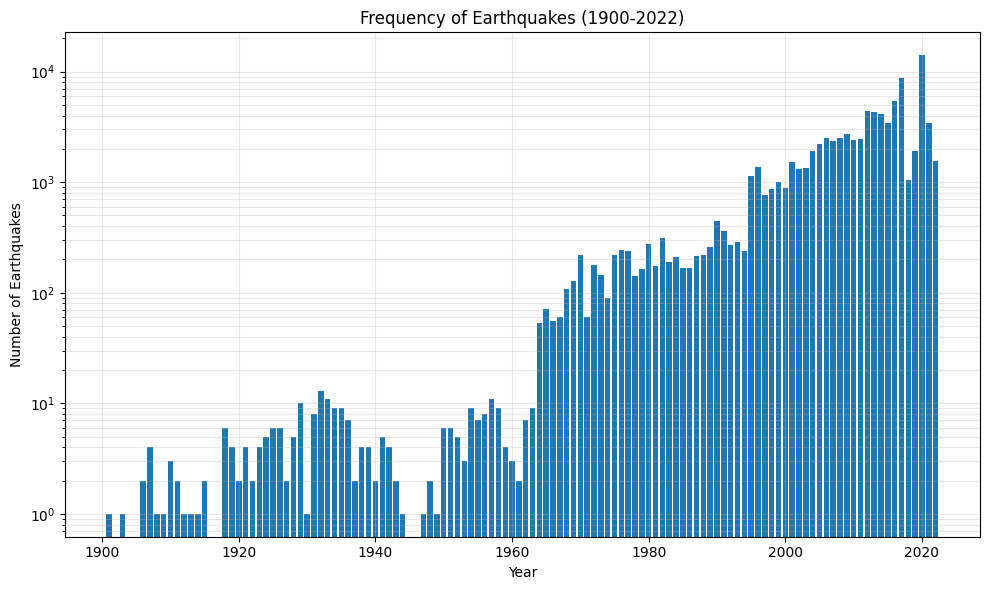

In [653]:
# Create a new, defragmented DataFrame
master_df = master_df.copy()

# Count number of earthquakes per year
master_df['YEAR'] = master_df['DATE'].dt.year
annual_earthquakes = master_df.groupby('YEAR').size().to_frame()

fig, ax = plt.subplots(figsize=(10, 6))


ax.bar(annual_earthquakes.index, annual_earthquakes.iloc[:, 0])
# Set y-axis to logarithmic scale
ax.set_yscale('log')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Earthquakes')
ax.tick_params(axis='y')

# Add grid lines
plt.grid(True, which='both', alpha=0.3)

# Add labels and title
plt.title('Frequency of Earthquakes (1900-2022)')

# Show the plot
fig.tight_layout()
plt.show()

<div style="text-align: justify;">
The chart above shows a 490% increase in detected seismic activity in 1964 compared to the previous year. This spike coincides the installation of the third seismic monitoring station (<a href="https://doi.org/10.3133/ofr20141218">Peterson and Hutt, 2014</a>), confirming the improved seismic monitoring capability introduced by the modern seismic network. For this reason, only earthquake events recorded from 1964 onwards will be considered for statistical analysis.
</div> 

In [655]:
# Drop rows older than 1964.
cutoff_date = pd.Timestamp('1964-01-01')
modern_df = clean_df[clean_df['DATE'] >= cutoff_date]

print(f'Earthquakes from 1964 to 2022 contains {modern_df.shape[0]} events.')

Earthquakes from 1964 to 2022 contains 2252 events.


##### Seismicity Declustering

<div style="text-align: justify;">
Seismicity is generally differentiated into independent (or background) events and dependent (or triggered) events that occur closely in space and time (<a href="https://doi.org/10.5078/corssa-52382934">Van Stiphout et al., 2012</a>). Independent events are associated with permanent stresses caused by tectonic forces, wherein the mainshock of an earthquake sequence is an example. In contrast, dependent events, such as foreshocks and aftershocks, are triggered by transient stress changes resulting from mechanical processes initiated by the mainshock (<a href="https://doi.org/10.4401/ag-8965">Kim, 2023</a>). Seismic events follow Omori's Law (<a href="https://www.scirp.org/reference/ReferencesPapers?ReferenceID=1541388">Omori, 1894</a>), where the mainshock is succeeded by an elevated number of aftershocks that decays over time following the power law relation. Seismographs, however, cannot differentiate independent from dependent events during recording. Therefore, earthquake catalogs undergo seismicity declustering to separate independent from dependent events and remove the latter, thereby yielding a realistic distribution of independent events (<a href="https://doi.org/10.1007/s10950-024-10221-8">Perry and Bendick, 2024</a>).<br>
<br>
Since 1960s, several different declustering algorithms were published, but all yield non-unique solutions because there is no known difference in the physical mechanism that causes an independent event from a dependent event (<a href="https://doi.org/10.1029/2018JB017120">Zaliapin and Ben-Zion, 2020</a>; <a href="https://doi.org/10.1007/s10950-024-10221-8">Perry and Bendick, 2024</a>). Among the most commonly implemented declustering algorithms include: window method (<a href="https://doi.org/10.1785/BSSA0640051363">Gardner and Knopoff, 1974</a>), link-based method (<a href="https://doi.org/10.1029/JB090iB07p05479">Reasenberg, 1985</a>), stochastic approach (epidemic-type aftershock sequence; <a href="https://doi.org/10.1198/016214502760046925">Zhuang et al., 2002</a>), and nearest-neighbor declustering (NND; <a href="https://doi.org/10.1103/PhysRevLett.101.018501">Zaliapin et al., 2008</a>). Window and link-based algorithms are both determistic approaches where each earthqukae is classified either as mainshock or aftershock. In addition, both models require subjectively chosen parameter for window sizes or link distance. This limitation is improved by a stochastic model, which recognizes the uncertainty of whether an event is independent or dependent, calculates the probability of an event being a background event, while eliminating the necessity of choosing arbitrary space-time parameters (<a href="https://doi.org/10.5078/corssa-52382934">Van Stiphout et al., 2012</a>). Lastly, nearest neighbor declustering generalizes distances between pairs of earthquake that combine information on location, time, and magnitude resulting in a bimodal classification of each event (i.e., background or triggered) (<a href="https://doi.org/10.1093/gji/ggv259">Zaliapin and Ben-Zion, 2015</a>).<br>
<br>
<a href="https://doi.org/10.1007/s10950-024-10221-8">Perry and Bendick (2024)</a> compared the performance of all the above declustering algorithms on different tectonic settings, including Japan, an island arc similar to the Philippines, and found NND as the most effective in removing triggered events while retaining the most number of events in the catalog. Although NND was found insufficient to effectively remove changes in background seismicity following large events, it can a accurately account for changes in background seismic productivity over longer timespans for the purpose of hazard analysis (<a href="https://doi.org/10.1785/0120190111">Teng and Baker, 2019</a>; <a href="https://doi.org/10.1007/s10950-024-10221-8">Perry and Bendick, 2024</a>). For this reason, NND will be carried out in this analyses using the <span style="font-style: italic;">Bruces</span> package (<a href="https://doi.org/10.5281/zenodo.7435145">Luu, 2022</a>).
</div> 

In [658]:
### Format date & time columns to Bruces readable
modern_df = modern_df.copy()

## DATE
# Strip extra spaces
modern_df['DATE'] = modern_df['DATE'].astype(str).str.strip()

# Standardize to YYYY-MM-DD 
modern_df['DATE'] = pd.to_datetime(
    modern_df['DATE'],
    format='%Y-%m-%d',
    #errors='coerce'    # modern_df['DATE'] == NaT if entry not equal to 'format'
).dt.strftime('%Y-%m-%d')

## TIME
# Strip extra spaces
modern_df['TIME'] = modern_df['TIME'].astype(str).str.strip()

def fix_time(time):
    """
    Function ensures 'HH:MM:SS.%f' format in column.
    - Appends '.000000' if time does not have milliseconds.
    """    
    # If no dot, assume no microseconds -> append '.000000'
    if '.' not in time:
        time += '.000000'
    
    # Attempt to parse as HH:MM:SS.%f, then reformat
    try:
        parsed = pd.to_datetime(time, format='%H:%M:%S.%f')
        return parsed.strftime('%H:%M:%S.%f')  # standardized string
    except ValueError:
        return None

modern_df['TIME'] = modern_df['TIME'].apply(fix_time)

# Combine date & time into 1 column
modern_df['datetime'] = modern_df['DATE'].astype(str) + ' ' + modern_df['TIME'].astype(str)
# Parse as datetime
modern_df['datetime'] = pd.to_datetime(modern_df['datetime'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
# Assign UTC timezone
modern_df['datetime'] = modern_df['datetime'].dt.tz_localize('UTC')
# Convert 'datetime' to Numpy array
datetime_arr = modern_df['datetime'].values.astype('datetime64[ns]') # Bruces reads NumPy datetime64 array or in decimal years

modern_df['datetime'].head()

338   1965-07-15 18:33:32.280000+00:00
356   1965-09-16 13:50:12.450000+00:00
364   1965-10-24 14:32:11.330000+00:00
525   1968-08-01 20:19:22.600000+00:00
608   1969-01-30 10:29:42.020000+00:00
Name: datetime, dtype: datetime64[ns, UTC]

In [659]:
#Set the number of threads for OpenMP/MKL routines to avoid potential memory leak.
os.environ["OMP_NUM_THREADS"] = "9"

# Convert catalog to Bruces readable
cat = bruces.Catalog(
    origin_times = datetime_arr,
    latitudes    = modern_df['LAT'].values.astype(float),
    longitudes   = modern_df['LON'].values.astype(float),
    depths       = modern_df['DEPTH'].values.astype(float),
    magnitudes   = modern_df['Mw'].values.astype(float)
)

# Apply declustering
decluster = nearest_neighbor(
    catalog = cat,
    return_indices = True,
    method = 'gaussian-mixture',
    d = 2.5,  # Fractal dimension of earthquake locations (~1.5 for epicenters; 2.5 for hypocenters; Zaliapin & Ben-Zion, 2020; Perry & Bendick, 2024)
    w = 0,  # exponential weight of previous event, i.e. b-value (Zaliapin & Ben-Zion, 2020; Perry & Bendick, 2024)
    use_depth = True,
    seed = None,
)

# OPTIONAL: Reasenberg declustering (disable NND to apply this method) 
#decluster = bruces.decluster.reasenberg(
#    catalog     = cat,
#    return_indices = True,
#    rfact       = 10,          # Number of crack radii around each event
#    xmeff       = None,        # Use minimum magnitude in the catalog if None
#    xk          = 0.5,         # Factor by which xmeff is raised in clustering
#    tau_min     = 1.0,         # Minimum look-ahead time (days)
#    tau_max     = 10.0,        # Maximum look-ahead time (days)
#    p           = 0.95         # Confidence level for observing the next event
#)

# declustered catalog
declustered_cat = modern_df.iloc[decluster].copy()
#declustered_cat

print(f'Declustered catalog contains {declustered_cat.shape[0]} events.')

Declustered catalog contains 1296 events.


C:\Users\romercarlo\anaconda3\envs\pygmt\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


##### Magnitude of Completeness ($M_c$)
<div style="text-align: justify;">
A critical aspect of quality control in earthquake catalogs is the assessment of the magnitude of completeness, which refers to the minimum magnitude above which all earthquakes in a certain region are reliably detected (<a href="https://doi.org/10.1038/337251a0">Rydelek and Sacks, 1989</a>; <a href="https://doi.org/10.1785/0120040007">Woessner and Wiemer, 2005</a>). In most catalogs, $M_c$ tends to decrease over time as seismic networks and analysis methods improve (<a href="https://doi.org/10.1785/0119990114">Wiemer and Wyss, 2000</a>). Estimating $M_c$ is based on the assumption that, within a given region, earthquake occurrence follows a power law approximation of the frequency-magnitude distribution (FMD), which is a statistical representation on how frequently earthquakes of various magnitudes occur. According to the Gutenberg-Richter (GR) relationship, the number of earthquakes decreases exponentially with increasing magnitude, given by the equation:<br>
<br>
$$\large{\log_{10}{N}=a-bM},$$<br>
where <span style="font-style: italic;">N</span> is the total number of earthquakes with magnitude <span style="font-style: italic;">M</span> or greater, and <span style="font-style: italic;">a</span> and <span style="font-style: italic;">b</span> (widely known as the <span style="font-style: italic;">b</span>-value) are positive constants representing the overall seismicity rate of the region and relative size distribution of large to small earthquakes, respectively. The <span style="font-style: italic;">b</span>-value is a key parameter in seismology due to its implications for earthquake behavior, seismic hazard, and tectonic processes (<a href="https://research-information.bris.ac.uk/en/studentTheses/detecting-and-characterising-seismicity-associated-with-volcanic-">Lapins, 2021</a> and references therein). The $M_c$ has a direct influence in <span style="font-style: italic;">b</span>-value (<span style="font-style: italic;">see</span> maximum likelihood method; <a href="https://www.scirp.org/reference/referencespapers?referenceid=2808518">Aki, 1965</a>; <a href="https://doi.org/10.1785/BSSA0730030831">Bender, 1983</a>), therefore accurate estimation is crucial as errors can lead incorrect estimation of the <span style="font-style: italic;">b</span>-value (<a href="https://doi.org/10.5078/corssa-00180805">Mignan and Woessner, 2012</a>; <a href="https://doi.org/10.1016/j.tecto.2013.12.001">El-Isa and Eaton, 2014</a>).<br>
<br>
There are several methods to compute $M_c$, with the Maximum Curvature (MAXC) method being one of the most robust (<a href="https://doi.org/10.1785/0119990114">Wiemer and Wyss, 2000</a>; <a href="https://doi.org/10.1007/s11069-012-0376-1">Bengoubou-Valérius and Gibert, 2013</a>). Computing $M_c$ using MAXC is straightforward by defining it as the inflection point of the FMD curve. In practice, MAXC uses the magnitude bin from the non-cumulative FMD containing the highest frequency of events (<a href="https://research-information.bris.ac.uk/en/studentTheses/detecting-and-characterising-seismicity-associated-with-volcanic-">Lapins, 2021</a>). Brief discussion of other models for estimating completeness can be found in <a href="https://doi.org/10.1785/0120040007">Woessner and Wiemer (2005)</a> and <a href="https://research-information.bris.ac.uk/en/studentTheses/detecting-and-characterising-seismicity-associated-with-volcanic-">Lapins (2021)</a>.<br>
<br>
At this stage of the analysis, $M_c$ is used to established the threshold value to be included for regression modelling. The MAXC method is applied on independent variables (i.e. $M_S$, $mb$, $M_L$, and $M_u$) only to remove potential noise from the predictors and improve reliability of the output model. The Python code for $M_c$ estimation is adapted from <a href="https://doi.org/10.1029/2021JB021910">Lapins et al. (2021)</a> which was made public in this <a href="https://github.com/sachalapins/bvalues">GitHub repository</a>.
</div> 

In [661]:
# Frequency-magnitude distribution function

def fmd(mag, mbin=0.1):
    '''
    Function computes for the frequency-magnitude distribution from a catalog 
    of earthquake magnitudes (any scale)

    Parameter:
    mag (pd.Series) - earthquake catalog (e.g. a column of 'Mw' records)

    Output:
    (tuple) - containing:
        mi (float) - magnitude bins
        nbmag (int)- number of events in bin
        cumnbmag (int) - cumulative number of events
    '''
    
    minmag = math.floor(min(mag/mbin)) * mbin # Lowest magnitude bin
    maxmag = math.ceil(max(mag/mbin)) * mbin # Highest magnitude bin
    mi = np.arange(minmag, maxmag + mbin, mbin) # Sequence of magnitude bins
    nbm = len(mi) # No. of magnitude bins
    cumnbmag = np.zeros(nbm) # Pre-allocate array for cumulative no. of events in mag bin and higher

    # Get cumulative no. of events in mag bin and higher
    for i in range(nbm):
        cumnbmag[i] = np.where(mag > mi[i] - mbin/2)[0].shape[0]
        
    # Get no. of events in each mag bin (non-cumulative frequency)
    nbmag = abs(np.diff(np.append(cumnbmag, 0)))
    
    return mi, nbmag, cumnbmag

In [662]:
# Function to estimate Mc using MAXC

def get_maxc(mag, mbin=0.1):
    '''
    Function computes for the magnitude of completeness 
    using the Maximum Curvature (MAXC) method

    Parameter:
    mag (pd.Series) - earthquake catalog (e.g. a column of 'Mw' records)

    Output:
    maxc (float) - Mc value rounded to nearest tenths.
    '''
    
    this_fmd = fmd(mag) # FMD
    maxc = this_fmd[0][np.argmax(this_fmd[1])] # Mag bin with highest no. of events
    return round(maxc, 1)

In [663]:
# Compute Mc of Ms, mb, ML, and Mu
# Creates a list containing individual dataframe of each magnitude scale paired with Mw

mag_scale = ['Ms', 'mb', 'ML', 'Mu']

mc_cat_list = []

for scale in mag_scale:
    catalog = declustered_cat[['Mw', scale]].dropna()
    mc = get_maxc(catalog[scale])

    # Drop rows where Mc > scale
    catalog = catalog.drop(catalog[catalog[scale] < mc].index)

    # Assign mc into a dynamically named variable and add to list
    string = 'mc_' + scale.lower()
    globals()[string] = catalog
    
    # Append each catalog with filtered rows to mc_cat_list
    mc_cat_list.append(globals()[string])

    # Show Mc of each magnitude scale
    print(f'The Mc for {scale} is {mc}.')

The Mc for Ms is 4.4.
The Mc for mb is 5.0.
The Mc for ML is 4.8.
The Mc for Mu is 4.3.


##### Removing outliers
<div style="text-align: justify;">
The remaining outliers in the dataset are removed using the interquartile range (IQR) method, a robust statistical approach that measures the spread of the data and identifies extreme values or outliers. This method has been proven effective in refining earthquake catalogs for analysis (<a href="https://doi.org/10.1785/gssrl.75.6.713">Reamer and Hinzen, 2004</a>; <a href="https://doi.org/10.3906/yer-0907-1">Tan et al., 2010</a>; <a href="https://doi.org/10.2478/s11600-013-0194-1">Tan et al., 2014</a>). In <a href="https://doi.org/10.5194/nhess-21-2059-2021">Tan (2021)</a>, outliers are removed through IQR by applying a cut-off value for large differences between each magnitude pair (e.g. $M_W-M_S$, $M_W-mb$, etc.), filtering out those that fall outside the range. Cut-off range in this dataset is set to the upper boundary of the fence because it excludes extreme values that could skew the results.
</div> 

In [665]:
# IQR function

def iqr_calc(cat_list):
    '''
    Function returns the cutoff value from the Interquartile Range
    and a refined refined catalog filtered using this cutoff value.

    Parameters:
    cat_list - list of pandas dataframes
            Each dataframe contains two columns with magnitude pairs.

    Output:
    mag_cutoff - a dictionary with the cutoff value for each magnitude pair.
    final_catalog - a list of the refined catalogs filtered using their respective cutoff values.
    
    '''
    mag_cutoff = {}
    final_catalog = []
    
    for catalog in cat_list:
        # Retrieve column names
        col_name = catalog.columns.tolist()
        mag_pair = f"{col_name[0]}-{col_name[1]}"
        
        # Compute difference between magnitude pairs
        catalog['mag_diff'] = (catalog[col_name[0]] - catalog[col_name[1]]).abs() 

        # Define IQR
        q1 = catalog['mag_diff'].quantile(0.25)
        q3 = catalog['mag_diff'].quantile(0.75)
        iqr = q3 - q1

        # Define cutoff value (i.e. upper boundary)
        cut_off = q3 + 1.5 * iqr
        cut_off = round(cut_off,1)

        # Filter df based on cutoff value
        refined_cat = catalog[abs(catalog['mag_diff']) <= cut_off]

        # Drop 'diff' column
        refined_cat = refined_cat.drop(columns=['mag_diff'])

        # Add to dictionary the cutoff values of each magnitude pair
        mag_cutoff[mag_pair] = cut_off

        # Append to list the refined catalog
        final_catalog.append(refined_cat)

    return mag_cutoff, final_catalog

In [666]:
iqr_cutoff, refined_catalog = iqr_calc(mc_cat_list)
iqr_cutoff

{'Mw-Ms': np.float64(1.1),
 'Mw-mb': np.float64(0.6),
 'Mw-ML': np.float64(1.2),
 'Mw-Mu': np.float64(1.1)}

Summary of magnitude scale pairs for statistical analysis.

In [668]:
mwms = refined_catalog[0]
mwmb = refined_catalog[1]
mwml = refined_catalog[2]
mwm = refined_catalog[3]

breakdown_df = pd.DataFrame({
                'Count': [mwms.shape[0], mwmb.shape[0], mwml.shape[0], mwm.shape[0]]
            }, index=['Mw-Ms', 'Mw-mb', 'Mw-ML', 'Mw-Mu'])

breakdown_df = breakdown_df.transpose()
breakdown_df.reset_index(inplace=True)#
breakdown_df['index'] = breakdown_df['index'].replace('Count', '') # Replace 'Count' string
breakdown_df.set_index('index', inplace=True)
breakdown_df.index.name = None # Remove index name
breakdown_df

,Mw-Ms,Mw-mb,Mw-ML,Mw-Mu
,827,791,511,63


### III. Regression
<div style="text-align: justify;">
Relationships between magnitude scales are commonly estimated using different types of regression. The most common approach for comparing magnitude relationships is standard least squares regression (SR), which computes for the relationship between two variables by minimizing the squared sum of vertical differences from the best-fit line, assuming that the measured error of independent variable approaches zero ($X\to0$) while the dependent variable has some error ($Y\gt0$). A variant of this approach is inverted SR (ISR), where the assumptions are reversed (i.e., $X \gt 0$ and $Y \to 0$) and minimizes the squared sum of horizontal differences from the best-fit line (<a href="https://doi.org/10.1785/0120060102">Castellaro and Bormann, 2007</a>; <a href="https://doi.org/10.1785/0120080237">Ristrau, 2009</a>; <a href="https://doi.org/10.1016/j.jafrearsci.2021.104326">Ezzelarab et al., 2021</a>).<br>
<br>
The third relationship estimator is called the general orthogoal regression (GOR), which is the used to deal with problems when both dependent and independent variables contain measurement errors. This estimator accounts for the effects of measurement errors in both variables, where the error variance, $\eta$, is the ratio between the variance of the error in the dependent variable of $\sigma_y^2$ and the variance of the error in the independent variable $\sigma_x^2$ (<a href="https://doi.org/10.1111/j.1365-246X.2006.02955.x">Castellaro et al., 2006</a>). Studies on magnitude scale relationships (<a href="https://doi.org/10.1785/0120060102">Castellaro and Bormann, 2007</a>; <a href="https://doi.org/10.1785/0120080237">Ristrau, 2009</a>; <a href="https://doi.org/10.1016/j.jafrearsci.2021.104326">Ezzelarab et al., 2021</a>) recommend GOR due to its ability to handle erros in both variables, and therefore will be implemented in this analysis.<br>
<br>
GOR assumes a linear relationship between two continuous variables - independent <span style="font-style: italic;">X</span> and dependent <span style="font-style: italic;">Y</span> - with corresponding variables for size errors <span style="font-style: italic;">x</span> and <span style="font-style: italic;">y</span>, respectively, defined by $y = ax+b$ where the estimators of slope <span style="font-style: italic;">a</span> and intercept <span style="font-style: italic;">b</span> are given by <a href="https://doi.org/10.1111/j.1365-246X.2006.02955.x">Castellaro et al. (2006)</a> as:<br>
<br>
$${a=\frac{S_{Y}^2 - \eta S_{X}^2 + \sqrt{\left(S_{Y}^2 - \eta S_{X}^2 \right) + 4 \eta S_{XY}^2}}{2S_{XY}}},$$
$${b = \bar Y - a \bar X},$$<br>

where $S_{X}^2$ and $S_{Y}^2$ are the variances of variables *X* and *Y*, respectively; $S_{XY}$ is the covariance between *X* and *Y*; and $\bar X$ and $\bar Y$ are the average values of the variables. On most cases, error variance $\eta$ is often unknown and assumed as 1 which provides good results. However, care should be taken when using $\eta=1$ as it may lead to wrong results if the true value of is very large  (<a href="https://doi.org/10.1111/j.1365-246X.2006.02955.x">Castellaro et al., 2006</a>).

</div> 

In [670]:
# Define regression variables
def gor_variables(df):
    '''
    Function defines the independent (x) and dependent (y) variables of
    the input magnitude pairs dataframe for regression modelling. Mw is the 
    default response variable.

    Parameters:
    df (pd.Dataframe) - a two-column dataframe, each containing a magnitude pair.

    Output:
    x (pd.Series) -  a series of values for the predictor variable.
    y (pd.Series) - a series of values for the response variable.
    '''
    mag_scales = ['Ms', 'mb', 'ML', 'Mu']

    col_names = df.columns.tolist()
    
    # Initialized variables
    y = None # Independent
    x = None # Dependent

    # Define variables from df
    for col in col_names:
        if col.lower() == 'mw':
            y = df[col]
        elif col.lower() in [mag.lower() for mag in mag_scales]:
            x = df[col]
        else:
            print('Incomplete dataset. Cannot proceed analysis.')
            return None

    return x, y

In [671]:
# GOR calculator
def gor_calc(df, eta=1.0):
    '''
    Function computes the slope (a) and intercept (b) using general orthogonal regression equation
    from a two column dataframe containing magnitude pairs Mw and from one of the 
    following: Ms, mb, ML, or M. 

    Parameters:
    df - two column dataframe of magnitude pairs
    eta - error variance ratio (default value is 1)

    output:
    a - slope of regression line
    b - intercept of regression line
    '''
    x, y = gor_variables(df)

    ## GOR
    # variance and covariances
    sx2 = np.var(x, ddof=1)
    sy2 = np.var(y, ddof=1)
    sxy = np.cov(x, y, ddof=1)[0][1]

    # Compute slope 'a'
    a = ((sy2 - eta * sx2) + np.sqrt((sy2 -eta * sx2)**2 + (4*eta*(sxy**2))))/(2 * sxy)

    # Compute intercept 'b'
    b = (y.mean()) - a * (x.mean())

    return a, b

<div style="text-align: justify;">
The bootstrap method was applied during the regression analysis to produce more robust results. This technique estimates the variability of parameters by repeatedly resampling the input dataset (<a href="https://doi.org/10.1214/aos/1176344552">Efron, 1979</a>). In <a href="https://doi.org/10.5194/nhess-21-2059-2021">Tan (2021)</a>, bootstrapping was carried out by randomly selecting 50% of the data and resimulating GOR 1,000 times to achieve 95% confidence interval of the <span style="font-style: italic;">a</span> and <span style="font-style: italic;">b</span>. The resulting magnitude scale relationship equations are then presented as the mean of slope and intercept with 2 standard deviation interval to reflect uncertainty.
 
</div> 

In [673]:
# Bootstrap sampling
def bootstrap_gor(df, sample_size=0.5):
    '''
    Function performs bootstrapping on the general orthogonal
    regression parameters with 95% confidence interval.

    Parameters:
    df (pd.DataFrame) - a two-column dataframe, each containing a magnitude pair.
    sample_size (float) - fraction of the data to be used for sampling, where 0 < sample_size <= 1 (default = 0.5)

    Output:
    (tuple) - containing:
        slopes (list) - a list of calculated slopes of the GOR.
        intercepts (list) - a list of calculated intercepts of the GOR.
        results (dict) - a dictionary containing the 95% confidence interval of slopes and intercepts.
    '''
    slopes = []
    intercepts = []
    results = {}
    
    #x, y = gor_variables(df)

    # Initialize Mersenne Twister RNG
    rng = np.random.RandomState(seed=25)
    
    # iterate regression 1000x using 50% of data
    for _ in range(1000):
        bootstrap_sample = df.sample(frac=sample_size, replace=True, random_state=rng)
        slope, intercept = gor_calc(bootstrap_sample)
        slopes.append(slope)
        intercepts.append(intercept)

    # OPTIONAL: Calculate 95% confidence intervals (2.5th to 97.5th percentile)
    slope_ci = np.percentile(slopes, [2.5, 97.5])
    intercept_ci = np.percentile(intercepts, [2.5, 97.5])

    # Add to results dictionary
    results['slope_ci'] = slope_ci
    results['intercept_ci'] = intercept_ci

    return slopes, intercepts, results

In [674]:
# IQR perfomed on slopes and intercepts sets
def iqr_bootstrap(dataset):
    '''
    Function uses IQR to remove outliers of input dataset.

    Parameter:
    dataset (pd.Series) - a pandas Series containing values from bootstrapping.

    Output:
    filtered_data (list) -  a list of the bootstrapped values where outliers are removed.
    '''
    q1 = np.percentile(dataset, 25)
    q3 = np.percentile(dataset, 75)
    iqr = q3 - q1
    
    # Define IQR whiskers
    min = q1 - 1.5 * iqr
    max = q3 + 1.5 * iqr
    
    #filter data
    filtered_data = [data for data in dataset if min < data < max]    

    return filtered_data

In [675]:
# Mean and standard deviation
def mean_sdev(filtered_slopes, filtered_intercepts):
    '''
    Function calculates arithmetic mean and standard deviation
    of input variables.

    Parameters:
    filtered_slopes (pd.Series) - contains a series of values representing slopes of the regression model
    filtered_intercepts (pd.Series) - contains a series of values representing intercepts of the regression model

    Output:
    (tuple) - containing:
        slope_mean (float) - average value of the input filtered_slopes series
        slope_sdev (float) - standard deviation derived from the input filtered_slopes series
        intercepts_mean (float) - average value of the input filtered_intercepts series 
        intercepts_sdev (float) - standard deviation derived from the input filtered_intercepts series
    '''
    # Slope
    slope_mean = sum(filtered_slopes)/len(filtered_slopes)
    slope_sdev = np.std(filtered_slopes)

    # Intercept
    intercepts_mean = sum(filtered_intercepts)/len(filtered_intercepts)
    intercepts_sdev = np.std(filtered_intercepts)

    return slope_mean, slope_sdev, intercepts_mean, intercepts_sdev

In [676]:
# Coefficient of determination (r-squared)
def r_squared(df, mean_slope, mean_intercept):
    '''
    Function computes for the coefficient of determination
    between magnitude pairs.

    Parameters:
    df (pd.DataFrame) - a two column dataframe containing values of magnitude pairs.
    mean_slope (float) - average of slope from the regression model
    mean_intercept (float) - average of intercept from the regression model

    Output:
    r_squared (float) - coefficient of determination of the regression model
    '''
    
    x, y = gor_variables(df)

    # Predict
    y_hat = mean_slope * x + mean_intercept

    # Total sum of squares
    sst = np.sum((y - np.mean(y)) ** 2)

    # Residual sum of squares
    ssr = np.sum((y - y_hat) ** 2)

    # R-squared
    r_squared = 1 - (ssr/sst)

    return r_squared

Putting all the functions together:

In [678]:
def magnitude_relationships(df):
    '''
    Function computes for the arithmetic mean, standard deviation,
    and r-squared of the slope and intercept of the general orthogonal
    regression.

    Parameters:
    df (pd.DataFrame) - a two column dataframe containing values of magnitude pairs.

    Output:
    (tuple) - containing:
        magnitude_pair (str) - the magnitude pair being modelled.
        slope_m (float) - average value of slopes
        slope_std (float) - standard deviation of slopes
        intercept_m (float) - average value of intercepts 
        intercept_std (float) - standard deviation of intercepts
        r2 (float) - coefficient of determination of the regression model
    '''
    # bootstrap samples for GOR
    slopes, intercepts, results = bootstrap_gor(df)
    # Remove outliers
    slope_filter = iqr_bootstrap(slopes)
    intercept_filter = iqr_bootstrap(intercepts)
    # Find mean and standard deviation of slopes and intercepts
    slope_m, slope_std, intercept_m, intercept_std = mean_sdev(slope_filter, intercept_filter)
    # Find r-squared of model
    r2 = r_squared(df, slope_m, intercept_m)

    # Define magnitude pair
    for col in df.columns:
        if 'mw' in col.lower():
            moment_mag = col
        else:
            magnitude = col

    magnitude_pair = f'{moment_mag}-{magnitude}'

    #return results, slope_m, intercept_m, r2
    return magnitude_pair, slope_m, slope_std, intercept_m, intercept_std, r2

In [679]:
# Define lists
magnitude_pairs = []
mean_slope = []
sdev_slope = []
mean_intercept = []
sdev_intercept = []
coeff_det = []

x = len(refined_catalog)

# Loop through catalog list
for i in range(0,x):
    mag_pair, m_a, sdev_a, m_b, sdev_b, r_sq = magnitude_relationships(refined_catalog[i])
    
    # Add output to corresponding list
    magnitude_pairs.append(mag_pair)
    mean_slope.append(round(m_a, 3))
    sdev_slope.append(round(sdev_a, 2))
    mean_intercept.append(round(m_b, 3))
    sdev_intercept.append(round(sdev_b, 2))
    coeff_det.append(round(r_sq, 2))

results = {'Magnitude Pair': magnitude_pairs,
           'a': mean_slope,
           'slope 2\u03C3': sdev_slope,
           'b': mean_intercept,
           'intercept 2\u03C3': sdev_intercept,
           'R\u00B2': coeff_det
}

regression_summary = pd.DataFrame(results)
regression_summary.set_index('Magnitude Pair', inplace=True)
regression_summary = regression_summary.transpose()
regression_summary

Magnitude Pair,Mw-Ms,Mw-mb,Mw-ML,Mw-Mu
a,0.751,1.205,1.093,1.333
slope 2σ,0.020,0.030,0.120,0.120
b,1.737,-0.963,-0.268,-1.857
intercept 2σ,0.090,0.160,0.610,0.620
R²,0.840,0.750,0.100,0.590


In [680]:
def plot_gor(df, regression_result_df, axis):
    '''
    Function defines the parameters necessary for plotting the
    GOR-based relationship and data density of each magnitude pairs.

    Parameters:
    df (pd.DataFrame) - a two column dataframe containing values of magnitude pairs.
    regression_result_df (pd.DataFrame) - contains the summary of GOR modelling of each magnitude pair.
    axis (matplotlib.axes._axes.Axes) - the axis on which to plot the GOR relationships and data density

    Output:
    None - the function is intended to plot the data on the provided axis.
    '''

    # Define dependent and independent variable columns of input
    x, y = gor_variables(df)

    # Define magnitude pair
    magnitude = None
    moment_mag = None

    for col in df.columns:
        if 'mw' in col.lower():
            moment_mag = col
        else:
            magnitude = col

    # Put magnitude pair results column in a list
    for col in regression_result_df.columns:
        if magnitude.lower() in col.lower():
            result_list = regression_result_df[col].tolist() # idx: [0] mean slope; [1] 2σ slope; [2] mean intercept; [3] 2σ intercept; [4] r squared
    
    # Set the bin size (cell size) to 0.1 with axes based on x and y
    bins = np.arange(min(y.min(), x.min()), max(y.max(), x.max()) + 0.1, 0.1)
    
    # bivariate histogram
    hist = axis.hist2d(x, y, bins=[bins, bins], cmap='ocean_r', density=True)

    # Add colorbar to indicate data density
    #cbar = plt.colorbar(hist[3], ax=ax)
    #cbar.set_label('Data Density')

    # Plot regression line
    df['Yhat_Mw'] = result_list[0] * x + result_list[2]
    axis.plot(x, df['Yhat_Mw'])

    # Plot the x = y line
    diagonal_line = np.linspace(bins[0], bins[-1], 100)
    axis.plot(diagonal_line, diagonal_line, color='grey', linestyle=':')

    # Delete column Yhat (for repeatability of dataset)
    df.drop(columns=['Yhat_Mw'], inplace=True)

    # Set major ticks at 1.0 intervals
    axis.xaxis.set_major_locator(MultipleLocator(1.0))
    axis.yaxis.set_major_locator(MultipleLocator(1.0))

    # Set minor ticks at 0.2 intervals
    axis.xaxis.set_minor_locator(MultipleLocator(0.2))
    axis.yaxis.set_minor_locator(MultipleLocator(0.2))

    # Add ticks on top and right sides of each plot
    axis.tick_params(axis='both', which='both', direction='in', top=True, right=True)

    # Add labels, title, and legend
    axis.set_xlabel(magnitude)
    axis.set_ylabel(moment_mag)

    axis.text(0.02, 0.98, f'Mw = {result_list[0]:.3f} * {magnitude} + ({result_list[2]:.2f})\nR\u00B2 = {result_list[4]}',
             fontsize=12, verticalalignment='top', horizontalalignment='left', transform=axis.transAxes)

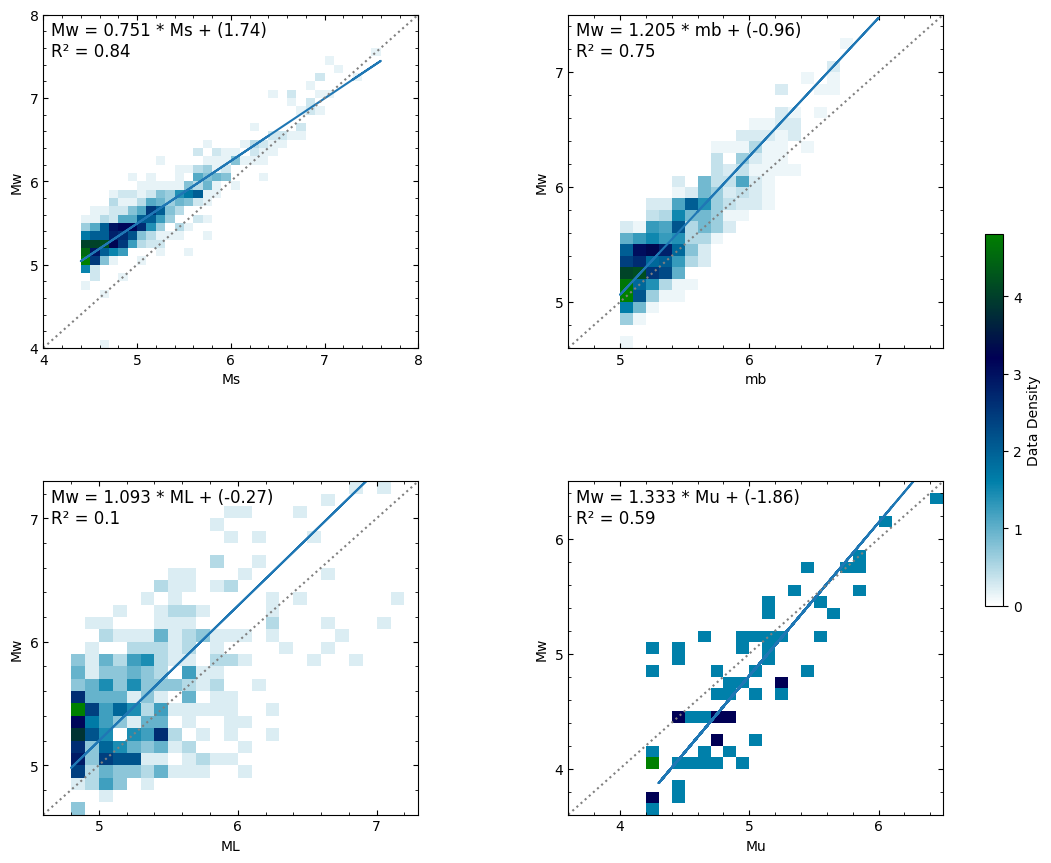

In [681]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

# Convert array into 1D for easier indexing 
ax_flat = ax.flatten()

# Calculate min and max density across all subplots for shared color scale
hist_values = []

for i in range(min(len(refined_catalog), len(ax_flat))):
    x, y = gor_variables(refined_catalog[i])
    bins = np.arange(min(y.min(), x.min()), max(y.max(), x.max()) + 0.1, 0.1)
    hist, xedges, yedges = np.histogram2d(x, y, bins=[bins, bins], density=True)
    hist_values.append(hist)

# Normalize data density across all magnitude pairs
vmin = np.min([np.min(h) for h in hist_values])
vmax = np.max([np.max(h) for h in hist_values])
norm = Normalize(vmin=vmin, vmax=vmax)

# Loop through the catalog and plot each magnitude relationship
for i in range(min(len(refined_catalog), len(ax_flat))):
    plot_gor(refined_catalog[i], regression_summary, ax_flat[i])

# Add a single colorbar for the entire figure
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='ocean_r'), ax=ax, orientation='vertical', fraction=0.02, pad=0.07)
cbar.set_label('Data Density')

plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

plt.show()

- Only $M_S$, $mb$, and $Mu$ show clear linear relationship with $M_W$.
    - $M_S - M_W$ are equal at $M_S = 7.0$.
    - $mb - M_W$ are equal at $mb = 4.7$.
    - $Mu - M_W$ are equal at $M = 5.6$.
- $M_L$ show a poor fit as the linear model isn't explaining much of the variance of the data.
    - Residuals indicate heteroscedasticity, particularly at $M_L \gt 6.0$. 

### IV. Homogenization
<div style="text-align: justify;">
The resultant GOR relationships will be used to standardize the entire catalog to moment magnitude scale ($M_W^*$). First, for events with multiple records on the same scale, the mean magnitude will be calculated. Conversion process will follow a priority order according to the highest coefficient of determination. For events with $M_W$, that value will be selected for $M_W^*$. If available unavailable, the value for $M_S$ will be considered, and so on. Values recorded on the $M_L$ scale will be excluded due to reliability concerns. As a result, events having $M_L$ only on record will dropped from the catalog.
</div> 

In [684]:
# Cleaning df
clean_main_df = catalog_cleaner(df)

In [685]:
# Define list that will contain calculated Mw
mw_calc = []

for index, row in clean_main_df.iterrows():
    mwc = np.nan

    # Drop row if all 'Mw', 'Ms', 'mb', 'Mu' are NaN
    if pd.isna(row[['Mw', 'Ms', 'mb', 'Mu']]).all():
        clean_main_df.drop(index, inplace=True)
        continue # Skip further processing for this row

    # if 'Mw' is NaN
    if pd.isna(row['Mw']):
        # Get the first non-NaN value following priority order
        for magnitude in ['Ms', 'mb', 'Mu']:
            if magnitude == 'Ms' and not pd.isna(row[magnitude]):
                mwc = round((regression_summary.loc['a', 'Mw-Ms'] * row[magnitude]) + regression_summary.loc['b', 'Mw-Ms'], 1)
                break
            elif magnitude == 'mb' and not pd.isna(row[magnitude]):
                mwc = round((regression_summary.loc['a', 'Mw-mb'] * row[magnitude]) + regression_summary.loc['b', 'Mw-mb'], 1)
                break
            elif magnitude == 'Mu' and not pd.isna(row[magnitude]):
                mwc = round((regression_summary.loc['a', 'Mw-Mu'] * row[magnitude]) + regression_summary.loc['b', 'Mw-Mu'], 1)
                break
    else:
        mwc = round(row['Mw'], 1)

    mw_calc.append(mwc)

# Add calculated Mw to table
clean_main_df.loc[:, 'Mwc'] = mw_calc

# Drop rows where Mwc < 0
# obtained when Mw/Ms/mb is 0
neg_mwc = clean_main_df[clean_main_df['Mwc'] < 0].index
clean_main_df.drop(neg_mwc, inplace=True)

# Show homogenized catalog
clean_main_df

,EVENT_TYPE,DATE,TIME,LAT,LON,DEPTH,DEPFIX,Mw,Ms,mb,ML,Mu,Mwc
0,ke,1901-12-14,22:57:00,14.0000,122.0000,0.0,,NaN,7.0,NaN,NaN,NaN,7.0
1,ke,1903-12-28,02:56:00,7.0000,127.0000,0.0,,7.1,7.0,NaN,NaN,NaN,7.1
2,ke,1906-06-19,11:22:41,20.0000,122.0000,60.0,,NaN,7.0,NaN,NaN,NaN,7.0
3,ke,1906-10-17,09:40:00,19.0000,121.0000,60.0,,NaN,NaN,7.3,NaN,NaN,7.8
4,ke,1907-04-18,20:59:48,14.0000,123.0000,35.0,TRUE,7.1,7.2,7.0,NaN,NaN,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87916,fe,2022-10-27,17:30:52.660000,17.8303,120.7281,20.3,,NaN,3.8,4.0,4.0,NaN,4.6
87921,fe,2022-10-28,21:56:02.450000,14.6388,122.0488,17.1,,NaN,4.3,4.3,4.0,NaN,5.0
87925,fe,2022-10-29,17:52:39.880000,11.2781,126.3035,16.6,,NaN,4.2,4.4,4.1,NaN,4.9
87959,ke,2022-11-08,14:30:01.420000,15.3639,120.8113,176.0,,5.2,4.0,5.3,NaN,NaN,5.2


##### Calculating $M_c$ and *b*-value
<div style="text-align: justify;">
At this stage, the $M_c$ is derived from the $M_{Wc}$ to determine the long-term minimum magnitude recorded by the network in the region. The $M_c$ varies in space and time, and is dependent on the ability of seismic network to consistently detect earthquakes. Therefore, a low value of $M_c$ is ideal because it indicates that the network is dense enough to detect smaller earthquakes (<a href="https://doi.org/10.1785/0120090130">Hutton et al., 2010</a>). <br>
<br>
The <span style="font-style: italic;">b</span>-value from the GR law is then estimated once the $M_c$ is defined. Values of <span style="font-style: italic;">b</span> exhibit a wide range of spatial and temporal variations with large values indicate common occurrence of small earthquakes, otherwise small values correspond to rarity of small earthquakes (<a href="https://doi.org/10.1029/92JB01891">Frolich and Davis, 1993</a>). Studies on long-term catalogs of seismically-active regions show <span style="font-style: italic;">b</span>=1 as the most observed value, but may vary between 0.3 and 2.5 on regional or local scale (<a href="https://doi.org/10.1016/0040-1951(91)90340-X">Imoto, 1991</a>; <a href="https://doi.org/10.1785/0120050629">Mishra et al., 2007</a>; <a href="https://doi.org/10.1016/j.tecto.2013.12.001">El-Isa and Eaton, 2014</a>). In addition, the <span style="font-style: italic;">b</span>-value has implications in fault kinematics (e.g. <span style="font-style: italic;">b</span> > 1 for normal, <span style="font-style: italic;">b</span>=1 for strike-slip, and <span style="font-style: italic;">b</span> < 1 for thrust faults) and dynamics (e.g. higher stress result to lower <span style="font-style: italic;">b</span> or sometimes reverse), and crustal heterogeneity and rheology (e.g. higher b-values occur in highly fractured, high pore pressure, or ductile rocks; <a href="https://research-information.bris.ac.uk/en/studentTheses/detecting-and-characterising-seismicity-associated-with-volcanic-">Lapins, 2021</a> and references therein).<br>
<br>
Calculating the <span style="font-style: italic;">b</span>-value from this catalog will use the maximum likelihood estimation (MLE) method, which assumes that the data are exponentially distributed and the maximum magnitude is at infinity (<a href="https://api.semanticscholar.org/CorpusID:117674598">Aki, 1965</a>; <a href="https://doi.org/10.1785/BSSA0730030831">Bender, 1983</a>; <a href="https://doi.org/10.5078/corssa-92330203">Naylor et al., 2010</a>). While an unbounded maximum magnitude is not physically plausible, it is assumed that the catalog is not large enough to sample the true maximum magnitude (<a href="https://doi.org/10.5078/corssa-92330203">Naylor et al., 2010</a>). The equation for estimating the <span style="font-style: italic;">b</span>-value is defined as:<br>
<br>
$${\hat{b}=\frac{\log(e)}{\bar M - (M_c -\Delta M/2)}},$$
<br>
where $\bar M$ is the mean magnitude, $\hat{b}$ is the estimate of <span style="font-style: italic;">b</span>-value, $M_c$ is the magnitude of completeness cutoff, and $\Delta M/2$ is the correction for finite binning width $\Delta M$. This equation highlights the sensitivity of the method to $M_c$ for estimating <span style="font-style: italic;">b</span>. In addition, computing the <span style="font-style: italic;">b</span>-value will always have a certain degree of uncertainty. This uncertainty can be lessened by applying the estimator introduced by <a href="https://doi.org/10.1785/BSSA0720051677">Shi and Bolt (1982)</a>, given as:<br>
<br>
$${\sigma(\hat b) = 2.3 {\hat b}^2 \sqrt{\frac{\sum_{i=1}^{N} (M_i-\bar M)^2}{N(N-1)}}},$$
<br>
where $\sigma(\hat b)$ is the standard error associated with a 90% confidence interval, $M_i$ is the magnitude for event <span style="font-style: italic;">i</span> above $M_c$, and $N$ is the number of earthquakes. The Python code for <span style="font-style: italic;">b</span>-value estimation is adapted from <a href="https://doi.org/10.1029/2021JB021910">Lapins et al. (2021)</a> which was made public in this <a href="https://github.com/sachalapins/bvalues">GitHub repository</a>.
</div>

In [687]:
def b_est(mag, mc, mbin = 0.1):
    '''
    Function estimates the b-value using maximum likelihood method,
    original Aki error estimate (Aki, 1965), and Shi & Bolt (1982)
    improved uncertainty estimate
    
    Parameters:
    mag (pd.Series) -  a single-column of the dataframe representing the magnitude catalog
    mc (float)-  completeness magnitude
    '''    
    mag_above_mc = mag[mag > round(mc, 1) - mbin / 2] # Magnitudes for events larger than cut-off magnitude mc
    n = mag_above_mc.shape[0] # No. of events larger than cut-off magnitude mc
    if n < 2:
        a = np.nan
        b = np.nan
        #aki_unc = np.nan
        shibolt_unc = np.nan
    else:
        mbar = np.mean(mag_above_mc) # Mean magnitude above cut-off Mc
        b = math.log10(math.exp(1)) / (mbar - (mc - mbin/2))
        a = math.log10(n) + b * mc # 'a-value' for seismicity rate
        # OPTIONAL: Use of Aki (1965) estimator with 68% confidence interval
        #aki_unc = b / math.sqrt(n) # Uncertainty estimate from Eq 4
        shibolt_unc = 2.3 * b**2 * math.sqrt(sum((mag_above_mc - mbar)**2) / (n * (n-1))) # Shi & Bolt (1982) uncertainty estimator

    return a, b, shibolt_unc #, aki_unc

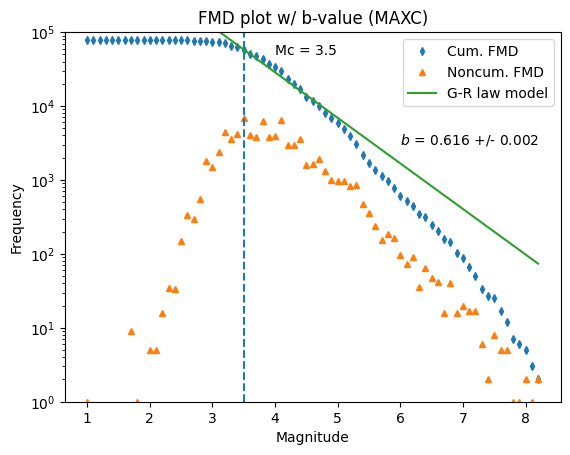

In [688]:
# Compute FMD estimates
cat_mi, cat_nbmag, cat_cumnbmag = fmd(clean_main_df['Mwc'])

# Compute Mc
cat_mc = get_maxc(clean_main_df['Mwc'])

# Estimate a-, b-values, and uncertainty
cat_a, cat_b, cat_shibolt_unc = b_est(clean_main_df['Mwc'], cat_mc)

plt.plot(cat_mi, cat_cumnbmag, 'd', markersize=4, label= 'Cum. FMD ')
plt.plot(cat_mi, cat_nbmag, '^', markersize=4, label='Noncum. FMD')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))), label='G-R law model')

plt.vlines(cat_mc, ymin=1, ymax=10**math.ceil(math.log10(clean_main_df.shape[0])), linestyles='dashed')

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(clean_main_df.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value (MAXC)')
plt.text(x=4, y=5e4, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=6, y=3e3, s="$b$ = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.legend()
plt.show()

<div style="text-align: justify;">
The FMD plot for the entire dataset (1901-2022) shows the linearity of the GR relation deviates above magnitude 5. Such deviation in higher magnitudes is common in most earthquake statistical studies, particularly those who rely on pre-modern (<1960s) catalogs for long-term seismicity analysis (e.g. <a href="https://doi.org/10.1785/0120090130">Hutton et al., 2010</a>; <a href="https://doi.org/10.1007/s12517-015-1929-x">Abdel Hafiez, 2015</a>; <a href="https://doi.org/10.5194/nhess-21-2059-2021">Tan, 2021</a>). In this dataset, the incompleteness of the pre-modern records may have caused underreporting of both low and high magnitude events, impacting the resultant high $M_c$ value. Another reason for the GR law deviation is the inherent uncertainty on magnitude conversion especially on older records. Prior to the widespread adoption of $M_W$, earthquakes were recorded using $M_L$, $mb$, or $M_s$, which all are unable to accurately record large earthquakes due to  magnitude saturation (<a href="https://doi.org/10.1029/JB084iB05p02348">Hanks and Kanamori, 1979</a>; <a href="https://doi.org/10.1007/978-3-030-10475-7_3-1">Bormann, 2020</a>). Therefore, converting of the older magnitudes to $M_W$ introduce systematic biases, resulting to non-linearity in the FMD plot.<br>
<br> 
The estimated <span style="font-style: italic;">b</span>-value for the entire dataset is low value, suggesting a relatively higher frequency of large earthquakes compared to smaller events. However, this does not necessarily mean that small earthquakes are uncommon. While PHIVOLCS records numerous small earthquakes daily (<span style="font-style: italic;">see</span> <a href="https://earthquake.phivolcs.dost.gov.ph/">PHIVOLCS-SOEPD</a>), the <span style="font-style: italic;">b</span>-value reflects the relative proportion of small to large events, not the absolute number of earthquakes. Despite the high number of recorded small earthquakes, frequent moderate to large ($M$>5.0) events have also been observed in the Philippines (<a href="https://www.phivolcs.dost.gov.ph/index.php/earthquake/destructive-earthquake-of-the-philippines">PHIVOLCS, 2018</a>; <a href="https://doi.org/10.7289/V5TD9V7K">NOAA, 2025</a>), particularly in the vicinity of Verde Island Passage where 15 earthquakes of at least $M_W$=5.0 have occurred since 2017, including six within a span of 5 months (<a href="http://doi.org/10.32858/temblor.225">Aurelio et al., 2021</a>; <a href="https://temblor.net/temblor/shaken-again-unraveling-earthquakes-southwestern-luzon-philippines-16573/">Llamas et al., 2025</a>).<br>
<br>
A possible explanation for the low <span style="font-style: italic;">b</span>-value is the estimated $M_c$ and its inherent uncertainties. The maximum curvature method tends to underestimate $M_c$ in large catalogs and on those with gradually curved FMDs that are indicative of spatial and temporal heterogeneity (<a href="https://doi.org/10.1785/0119990114">Wiemer and Wyss, 2000</a>; <a href="https://doi.org/10.5078/corssa-00180805">Mignan and Woessner 2012</a>). An incorrect estimate of $M_c$ may bias the <span style="font-style: italic;">b</span>-value downward (<a href="https://doi.org/10.1093/gji/ggae159">Tinti and Gasperini, 2024</a>). Nonetheless, the low <span style="font-style: italic;">b</span>-value is indicative of high regional stress, particularly on major convergent zones that bound the entire archipelago (<a href="https://doi.org/10.1038/nature04094">Schorlemmer et al., 2005</a>; <a href="https://doi.org/10.1016/j.jseaes.2012.10.007">Aurelio et al., 2013</a>). <a href="https://doi.org/10.1038/nature04094">Schorlemmer et al. (2005)</a> emphasized that spatial heterogeneity in <span style="font-style: italic;">b</span>-values is directly related to variations of differential stress, a pattern confirmed in the Philippine setting, where a study of various seismic source zones revealed <span style="font-style: italic;">b</span>-values ranging from 0.62 to 1.72 (<a href="https://doi.org/10.1177/8755293019900521">Peñarubia et al., 2020</a>).<br>
<br>
Since the dataset used in this analysis spans multiple decades with varying levels of completeness, it is more appropriate to use the Entire Magnitude Range (EMR; <a href="https://doi.org/10.1785/0120040007">Woessner and Wiemer, 2005</a>) method to estimate  $M_c$. The EMR method is a two part procedure that utilizes maximum-likelihood estimation to (1) model the complete part of the catalog and (2) sample the incomplete part of the FMD, resulting to a more robust estimate of $M_c$. It is assumed the complete part of the catalog follows a power-law behavior, thus the MLE (<a href="https://api.semanticscholar.org/CorpusID:117674598">Aki, 1965</a>; <a href="https://doi.org/10.1785/BSSA0730030831">Bender, 1983</a>) is used to reestimate <span style="font-style: italic;">a</span>- and <span style="font-style: italic;">b</span>-values. For events below $M_c$, a normal cumulative distribution function (CDF) $q(M|\mu, \sigma)$ that describes the likelihood that an earthquake of certain magnitude will be detected by the seismic network is fitted to the data (<a href="https://doi.org/10.1785/0120040007">Woessner and Wiemer, 2005</a>). It assumes magnitudes $M>M_c$ are almost always detected, hence a probability of 1. Otherwise, the probability is given as:<br>
<br>
$${q(M|\mu,\sigma)=\frac{1}{\sigma\sqrt{2\pi}}\int_{-\infty }^{M_c} \exp\left( -\frac{(M-\mu)^2}{2{\sigma}^2} \right)dM},$$<br>
where $\mu$ is the magnitude at which 50% of the earthquakes are detected and $\sigma$ is the standard deviation describing the width of the range where earthquakes are partially detected. The best fitting model is the one that maximizes the log-likelihood function of $\mu$, $\sigma$, <span style="font-style: italic;">a</span>, and <span style="font-style: italic;">b</span>.<br>
<br>
Implementing the EMR method adapts the code provided in <a href="https://doi.org/10.5078/corssa-00180805">Mignan and Woessner (2012)</a>, which was the R language version of ZMAP software functions written in Matlab (<a href="https://doi.org/10.1785/gssrl.72.3.373">Wiemer, 2001</a>; <a href="https://doi.org/10.1785/0120040007">Woessner and Wiemer, 2005</a>). The code starts with an initial estimate of $M_c$, computed using the MAXC method, to distinguish between the complete and incomplete parts of the magnitude distribution. The <span style="font-style: italic;">a</span>- and <span style="font-style: italic;">b</span>-values for the complete part of catalog are then computed using MLE as done earlier. For the incomplete part, the parameters $\mu$ and $\sigma$ of the normal distribution are initially unknown, thus a non-linear least-squares fitting is applied on the normal CDF to determine the parameters that best fits the relationship between magnitude and normalized cumulative counts. A logarithm of the Poisson probability density is then performed to determine the best-fitting model parameters that maximizes the log-likelihood.
</div>

In [690]:
# Entire Magnitude Range method (EMR) [Mignan & Woessner, 2012]
def get_emr(mag, mbin=0.1):
    from scipy.stats import norm
    
    FMD = fmd(mag, mbin)  # Call the fmd function to get FMD based on mag and mbin
    nbm = len(FMD[0])   # Number of magnitude bins
    
    # Define initial estimates of parameters
    McMAXC = get_maxc(mag, mbin)  # Get Mc from maxc function
    mu = abs(McMAXC / 2)  # Initial mean value
    sig = abs(McMAXC / 4)  # Initial standard deviation
    if mu > 1:  # Adjust mu and sig if mu is greater than 1
        mu = abs(McMAXC / 10)
        sig = abs(McMAXC / 20)
    McBound = McMAXC  # Assign McMAXC to McBound
    Mco = McBound - 0.3 + (np.arange(9)) / 10  # Create values for testing different potential Mc 
    
    # Define arrays that will contain parameter values
    params = np.zeros((9, 4))  # Initialize parameter matrix for a, b, mu, sigma
    prob = np.zeros(9)  # Initialize array for log-likelihood probabilities
    savedmodel = np.zeros((9, nbm))  # Initialize saved model array
    
    #Loop through each candidate Mc and test how well the model fits the data for each value
    for i in range(9):
        indmag = np.where(mag > Mco[i] - mbin / 2)[0]  # Indices of M>=Mc
        nbev = len(indmag) 

        b = np.log10(np.exp(1)) / (np.mean(mag[indmag]) - (Mco[i] - mbin / 2))  # Calculate b-value
        a = np.log10(len(indmag)) + b * Mco[i]  # Calculate a-value

        cumN = 10 ** (a - b * FMD[0])  # Cumulative number of earthquakes (solve N in GR law)
        params[i, 0] = a  # Store a-value 
        params[i, 1] = b  # Store b-value

        cumNtmp = 10 ** (a - b * (np.max(FMD[0]) + mbin))  # Extrapolated cumN
        cumNtmp = np.append(cumN, cumNtmp) # Append cumNtmp to cumN
        N = np.abs(np.diff(cumNtmp))  # Number of events in each bin
        
        # Combine N, FMD[0], FMD[1] into df
        data = pd.DataFrame({'N': N, 'm': FMD[0], 'Nd': FMD[1]})
        
        # Create subset of complete and incomplete events
        indLow = np.where(FMD[0] < Mco[i])[0]  # Indices of M<Mc
        indHigh = np.where(FMD[0] >= Mco[i])[0]  # Indices of M>=Mc
        dataTest = pd.DataFrame({'N': data['N'].iloc[indLow], 'm': data['m'].iloc[indLow], 'Nd': data['Nd'].iloc[indLow]})  # Subset containing M<Mc
        dataTmp = pd.DataFrame({'N': data['N'].iloc[indHigh], 'm': data['m'].iloc[indHigh], 'Nd': data['Nd'].iloc[indHigh]})  # Subset containing M>=Mc

        checkNo0 = np.where(dataTest['Nd'] != 0)[0]  # Indices where non-cumulative count is not zero
        dataTest = dataTest.iloc[checkNo0]  # Remove zero-count entries
        Nmax = np.max(dataTest['Nd'])  
        Mmintmp = np.min(dataTest['m'])  

        dataTest['Nd'] = dataTest['Nd'] / Nmax  # Normalize Nd by Nmax
        dataTest['m'] = dataTest['m'] - Mmintmp  # Shift magnitudes to start at 0
        data4fit = pd.DataFrame({'N': dataTest['Nd'], 'm': dataTest['m']})  # Prepare data for fitting

        # Define CDF of normal distribution estimator
        def fit_func(m, mean, sd):
            return norm.cdf(m, loc=mean, scale=sd)
        
        # Perform non-linear least squares fit to normal distribution
        popt, _ = curve_fit(fit_func, data4fit['m'], data4fit['N'], p0=[mu, sig], maxfev=1000)
        params[i, 3] = popt[1]  # Store standard deviation from fit in params
        params[i, 2] = popt[0]  # Store mean from fit in params

        dataTest['N'] = norm.cdf(dataTest['m'], loc=popt[0], scale=popt[1]) * Nmax  # Calculate fitted model values
        dataTest['m'] = dataTest['m'] + Mmintmp  # Restore original magnitude scale
        dataTest['Nd'] = dataTest['Nd'] * Nmax  # Restore original non-cumulative count scale
        
        # New df with predicted data combining low and high magnitudes
        dataPred = pd.DataFrame({'N': np.concatenate([dataTest['N'], dataTmp['N']]),
                                 'm': np.concatenate([dataTest['m'], dataTmp['m']]),
                                 'Nd': np.concatenate([dataTest['Nd'], dataTmp['Nd']])})
        dataPred['N'] = np.round(dataPred['N']).astype(int)  # Round predicted counts
        savedmodel[i, np.concatenate([checkNo0, indHigh])] = dataPred['N']  # Save predicted model

        # Logarithm to the base 10 of Poisson probability density
        probtmp = np.zeros(nbm)
        CheckNo0 = np.where(dataPred['N'] != 0)[0]  # Indices where model count is not zero
        Pmodel = dataPred['N'][CheckNo0]  # Model counts
        Pdata = dataPred['Nd'][CheckNo0]  # Observed counts

        probtmp[CheckNo0] = 1 / np.log(10) * (-Pmodel + Pdata * np.log(Pmodel) - gammaln(Pdata + 1))  # Calculate Poisson log-likelihood
        prob[i] = -np.sum(probtmp)  # Total probability for this iteration

    indbestfit = np.argmin(prob)  # Find the index of the best-fitting model

    # Estimate b-value uncertainty (Shi & Bolt, 1982)
    idxmag = np.where(mag > Mco[indbestfit] - mbin / 2)[0] # Indices of M >= Mc
    compMag = mag[idxmag]  # Magnitudes of events M >= Mc
    meanMag = np.mean(compMag) # Mean of compMag
    sbN = len(compMag) # number of events M>=Mco
    sigma_b = 2.3 * params[indbestfit, 1]**2 * math.sqrt(sum((compMag - meanMag)**2) / (sbN * (sbN-1)))
    
    # Store results in dict
    res = {'Mc': Mco[indbestfit], 'a': params[indbestfit, 0], 'b': params[indbestfit, 1],
           'sigma_b': sigma_b, 'mu': params[indbestfit, 2], 'sigma': params[indbestfit, 3],
           'model': savedmodel[indbestfit, :], 'Mco': Mco, 'prob': prob}
    return res


In [691]:
in_mag = clean_main_df['Mwc'].values

emr_result = get_emr(in_mag)
emr_result

{'Mc': np.float64(3.9000000000000004),
 'a': np.float64(7.424537855664205),
 'b': np.float64(0.7321173345008398),
 'sigma_b': np.float64(0.0033168653648717136),
 'mu': np.float64(2.256252016571794),
 'sigma': np.float64(0.4562068553627266),
 'model': array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 5.000e+00, 0.000e+00, 2.000e+01, 3.800e+01,
        7.000e+01, 1.230e+02, 2.070e+02, 3.330e+02, 5.130e+02, 7.610e+02,
        1.084e+03, 1.485e+03, 1.962e+03, 2.500e+03, 3.080e+03, 3.676e+03,
        4.260e+03, 4.805e+03, 5.290e+03, 5.701e+03, 6.034e+03, 5.754e+03,
        4.862e+03, 4.107e+03, 3.470e+03, 2.932e+03, 2.477e+03, 2.093e+03,
        1.768e+03, 1.494e+03, 1.262e+03, 1.066e+03, 9.010e+02, 7.610e+02,
        6.430e+02, 5.430e+02, 4.590e+02, 3.880e+02, 3.280e+02, 2.770e+02,
        2.340e+02, 1.980e+02, 1.670e+02, 1.410e+02, 1.190e+02, 1.010e+02,
        8.500e+01, 7.200e+01, 6.100e+01, 5.100e+01, 4.300e+01, 3.700e+01,
        3.

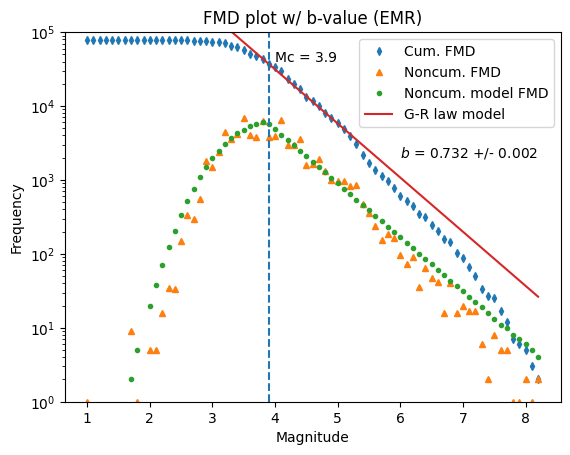

In [692]:
plt.plot(cat_mi, cat_cumnbmag, 'd', markersize=4, label= 'Cum. FMD ')
plt.plot(cat_mi, cat_nbmag, '^', markersize=4, label='Noncum. FMD')
plt.plot(cat_mi, emr_result['model'], 'o', markersize=3, label='Noncum. model FMD') # best fit model


plt.plot(cat_mi, (10**(emr_result['a'] - (emr_result['b'] * cat_mi))), label='G-R law model') # estimated b-value slope

plt.vlines(emr_result['Mc'], ymin=1, ymax=10**math.ceil(math.log10(clean_main_df.shape[0])), linestyles='dashed')

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(clean_main_df.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value (EMR)')
plt.text(x=4, y=4e4, s="Mc = " + str(round(emr_result['Mc'], 1)))
plt.text(x=6, y=2e3, s="$b$ = " + str(round(emr_result['b'], 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.legend()
plt.show()

<div style="text-align: justify;">
Computing $M_c$ using the EMR method increased the cutoff magnitude for reliably detectable earthquakes by the seismic network. Consequently, the <span style="font-style: italic;">b</span>-value slightly increased, though the deviation is still noticeable suggesting possible underreported $M \gt 5.4$ events. This deviation is evident in the resulting EMR model, where it underpredicts the observed events at higher magnitudes. One possible reason for this discrepancy is that the model depends on the chosen parameters, which may result in discontinuous curvature relative to the noncumulative FMD (e.g. <a href="https://doi.org/10.5078/corssa-00180805">Mignan and Woessner, 2012</a>).
</div>